Face detection with OpenCV isn't something new or complicated. There is however the aspect of face recognition. Combining all of that plus some PIL image processing we can make a fun machine vision app.

In [1]:
import pytest
import ipytest

ipytest.autoconfig()

### Detect faces, draw memes

In [2]:
import os

import cv2
import numpy as npframe
import PIL.Image
import PIL.ImageOps
import PIL.ImageFont
import PIL.ImageDraw
from IPython.display import display

In [3]:
eye_cascade = cv2.CascadeClassifier('/home/xilinx/jupyter_notebooks/pynq-memes/data/haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('/home/xilinx/jupyter_notebooks/pynq-memes/data/haarcascade_frontalface_default.xml') 

In [4]:
def detect_faces_on_frame(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    return face_cascade.detectMultiScale(gray, 1.3, 5)

In [5]:
ipytest.clean_tests()

def test_if_face_is_detected():
    image = PIL.Image.open('/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/test_face.jpg')
    frame = npframe.array(image)
    faces = detect_faces_on_frame(frame)
    assert len(faces) == 1
    x, y, w, h = faces[0]
    assert [x, y, w, h] == [213,  94, 119, 119]

ipytest.run('-qq')

.                                                                        [100%]


In [6]:
def mark_faces_on_frame(frame, faces):
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]

        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    return frame

In [7]:
def crop_face(image, face):
    x, y, width, height = expand_face_coordinates_if_possible(face, image)
    return image.crop((x, y, x + width, y +height))

In [9]:
def expand_face_coordinates_if_possible(face, image, expand_by=60):
    image_width, image_height = image.size
    x, y, width, height = face
    x = x - expand_by
    if x < 0:
        x = 0
    y = y - expand_by
    if y < 0:
        y = 0
    width = width + expand_by * 2
    if width + x > image_width:
        width = image_width - x
    height = height + expand_by * 2
    if height + y > image_height:
        height = image_height - y
    return x, y, width, height

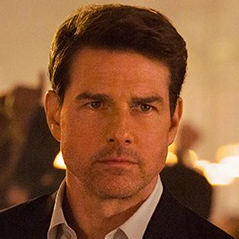

.                                                                        [100%]


In [10]:
ipytest.clean_tests()

def test_if_face_is_cropped():
    image = PIL.Image.open('/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/test_face.jpg')
    face = [213,  94, 119, 119]
    result = crop_face(image, face)
    assert result.size == (239, 239)
    display(result)

ipytest.run('-qq')

In [11]:
ipytest.clean_tests()

def test_if_coordinates_are_expanded():
    image = PIL.Image.new('RGB', (400, 400))
    face = (100, 100, 50, 50)
    result = expand_face_coordinates_if_possible(face, image, expand_by=20)
    assert result == (80, 80, 90, 90)


def test_if_left_side_edge_is_handled():
    image = PIL.Image.new('RGB', (400, 400))
    face = (0, 0, 50, 50)
    result = expand_face_coordinates_if_possible(face, image, expand_by=20)
    assert result == (0, 0, 90, 90)


def test_if_right_side_edge_is_handled():
    image = PIL.Image.new('RGB', (400, 400))
    face = (350, 350, 50, 50)
    result = expand_face_coordinates_if_possible(face, image, expand_by=20)
    assert result == (330, 330, 70, 70)


ipytest.run('-qq')

...                                                                      [100%]


In [12]:
def draw_meme(image, face):
    image = crop_face(image, face)
    image = PIL.ImageOps.expand(image, border=20, fill='deeppink')
    
    w, h = image.size
    overlay = PIL.Image.new('RGB', (w, h + 60), (255, 20, 147))
    overlay.paste(image, (0, 0))

    font_size = 30
    if w < 200:
        font_size = 20

    draw = PIL.ImageDraw.Draw(overlay)
    font = PIL.ImageFont.truetype("/home/xilinx/jupyter_notebooks/pynq-memes/data/COMIC.TTF", font_size)
    draw.text((20, h),"PYNQ Hero!",(255,255,255),font=font)
    return overlay

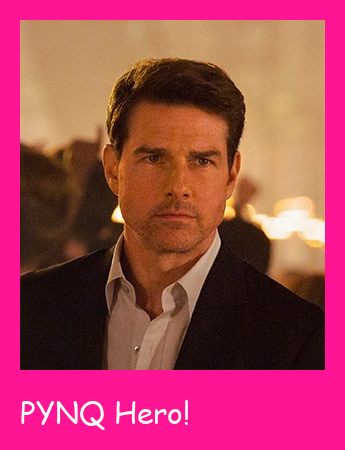

.                                                                        [100%]


In [13]:
ipytest.clean_tests()

def test_if_meme_is_drawn():
    image = PIL.Image.open('/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/test_face.jpg')
    face = (175, 17, 185, 230)
    result = draw_meme(image, face)
    assert result
    display(result)

ipytest.run('-qq')

In [14]:
def display_memes_on_one_frame(memes):
    padding = 5
    overlay = PIL.Image.new('RGB', (1920, 1080), (255, 20, 147))
    x = padding
    y = padding
    max_height_in_row = 0
    for meme in memes:
        overlay.paste(meme, (x, y))
        w, h = meme.size
        x += w
        x += padding
        if max_height_in_row < h:
            max_height_in_row = h
        if x + w >= 1900:
            x = padding
            y += max_height_in_row
            y += padding
            max_height_in_row = 0
    return overlay

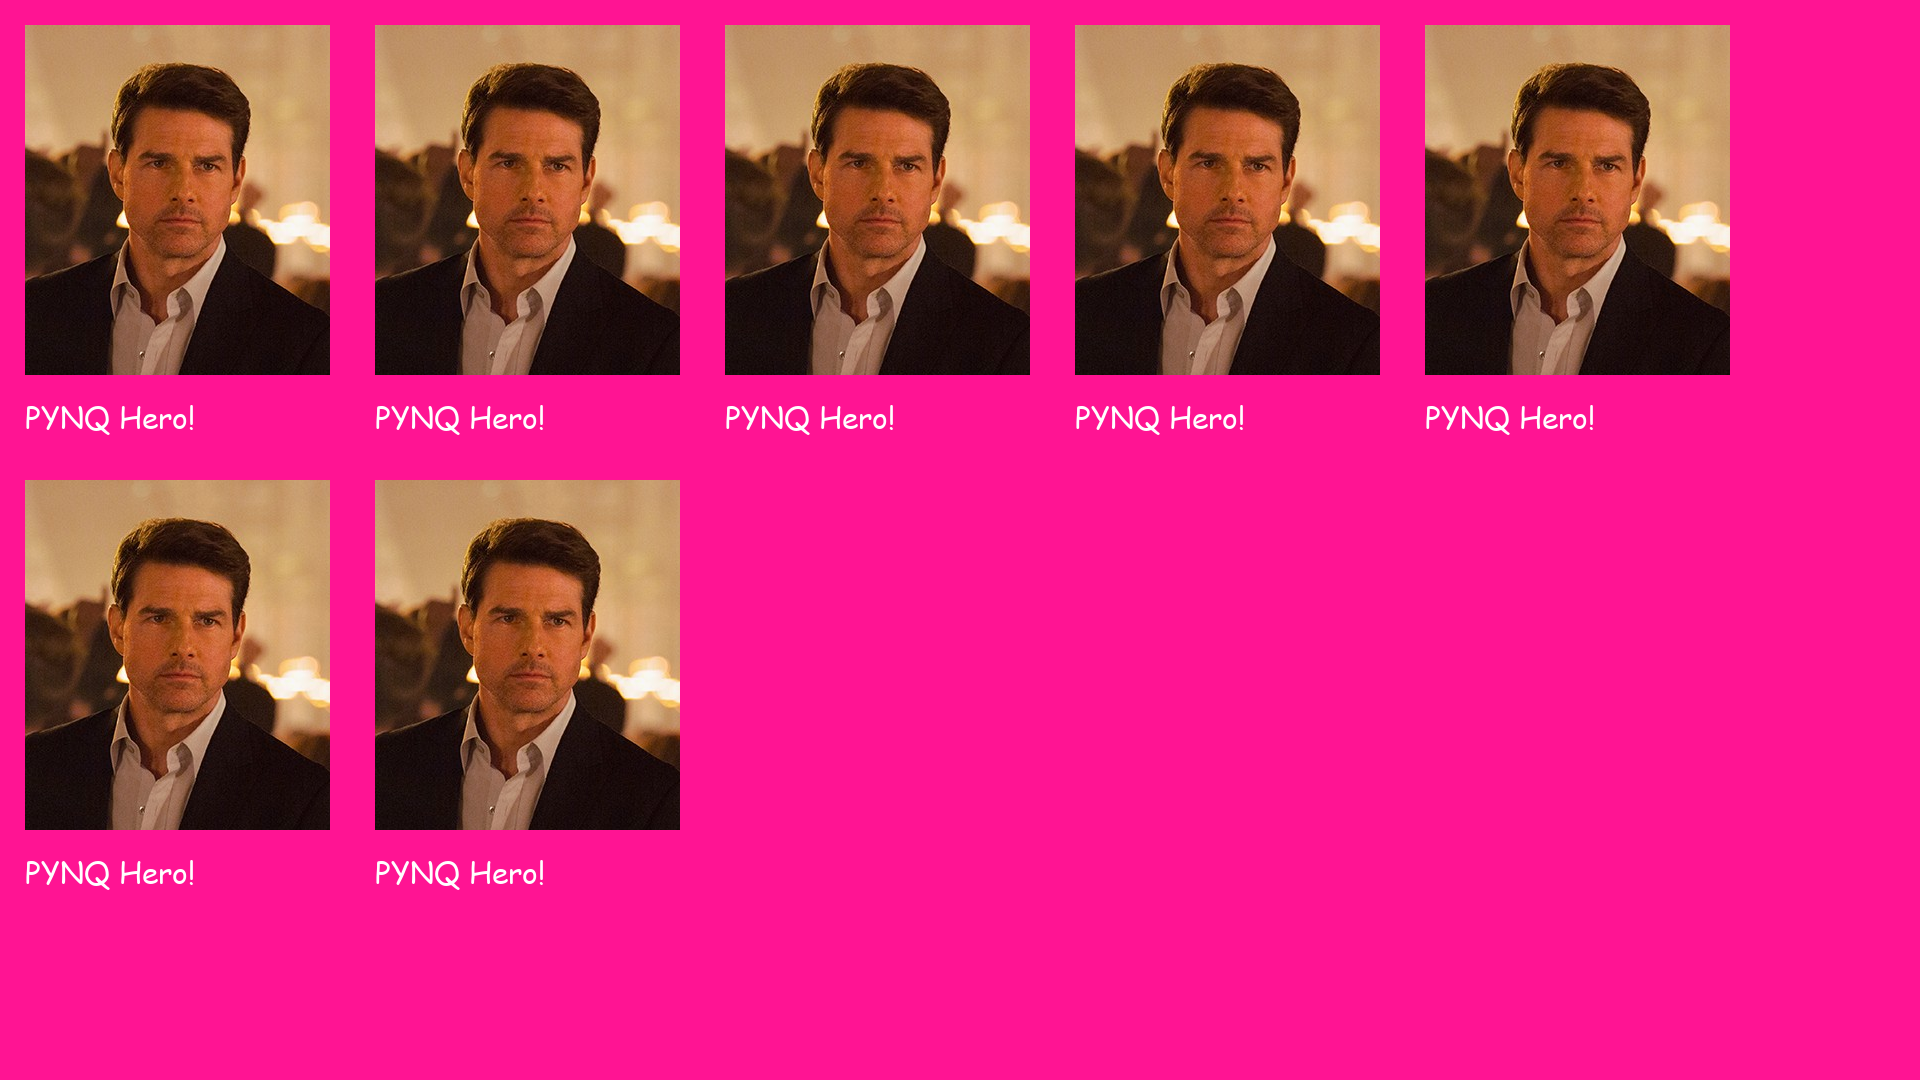

.                                                                        [100%]


In [15]:
ipytest.clean_tests()

def test_if_memes_are_drawn_on_single_frame():
    image = PIL.Image.open('/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/meme.png')
    memes = [image] * 7
    result = display_memes_on_one_frame(memes)
    assert result.size == (1920, 1080)
    display(result)

ipytest.run('-qq')

In [16]:
def get_image_from_frame(frame):
    return PIL.Image.fromarray(frame)

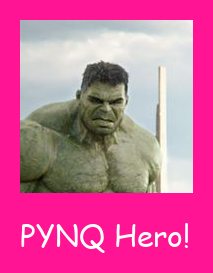

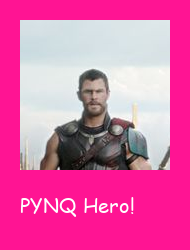

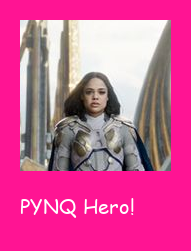

.                                                                        [100%]


In [17]:
ipytest.clean_tests()

def test_integration():
    image_path = "/home/xilinx/jupyter_notebooks/pynq-memes/data/a2.jpg"
    source_image = PIL.Image.open(image_path)
    current_frame = npframe.array(source_image)
    faces = detect_faces_on_frame(current_frame)
    created_memes = []

    for face in faces:
        meme = draw_meme(source_image, face)
        created_memes.append(meme)
        display(meme)
    
    display_memes_on_one_frame(created_memes)
    assert len(created_memes) == 3

ipytest.run('-qq')


# Face recognition - optional
This requires installing "face_recognition" package which on PYNQ-Z2 can take way over an hour.
The face comparison also takes some time.

#### Reference image:

![base image](data/tests/test_face.jpg "Ethan Hunt")

#### Other Ethan Hunt image:

![other image](data/tests/other_ethan.jpg "Ethan Hunt")

#### Ethan Hunt in disquise image:

![other image](data/tests/russian_ethan.jpg "Ethan Hunt")
![other image](data/tests/russian_ethan2.jpg "Ethan Hunt")

#### Other face image:

![other image](data/tests/other_face.jpg "Other")


In [18]:
class FaceDetectionError(Exception):
    pass


def get_encoding(image_path):
    face = face_recognition.load_image_file(image_path)
    return face_recognition.face_encodings(face)[0]


def compare_faces(reference_encoding, analyzed_image_file):
    try:
        unknown_encoding = get_encoding(analyzed_image_file)
    except IndexError:
        raise FaceDetectionError()
    else:
        return face_recognition.compare_faces([reference_encoding], unknown_encoding)[0]

In [19]:
import face_recognition

ipytest.clean_tests()

def test_face_recognition():
    hunt_encoding = get_encoding("/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/test_face.jpg")
    
    assert compare_faces(hunt_encoding, '/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/other_ethan.jpg')
    assert not compare_faces(hunt_encoding, '/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/other_face.jpg')
    assert not compare_faces(hunt_encoding, '/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/russian_ethan.jpg')
    with pytest.raises(FaceDetectionError):
        assert not compare_faces(hunt_encoding, '/home/xilinx/jupyter_notebooks/pynq-memes/data/tests/russian_ethan2.jpg')

ipytest.run('-qq')

.                                                                        [100%]


# Meme machine vision app
### Detect faces on HDMI-IN, draw memes, display them as one frame on HDMI-out.

Get a frame from HDMI input, detect faces, make memes, draw a 720p frame on the output.

In [10]:
from time import sleep

from pynq.overlays.base import BaseOverlay
from pynq.lib.video import *

base = BaseOverlay("base.bit")

In [11]:
hdmi_in = base.video.hdmi_in
hdmi_out = base.video.hdmi_out

hdmi_in.configure(PIXEL_RGB)
hdmi_out.configure(hdmi_in.mode, PIXEL_RGB)

hdmi_in.start()
hdmi_out.start()

In [16]:
# hdmi_in.tie(hdmi_out)

In [19]:
run = 0
memes_displaying = False

while run < 4:
    print(run)
    frame = hdmi_in.readframe()
    image = get_image_from_frame(frame)
    faces = detect_faces_on_frame(frame)

    created_memes = []

    for face in faces:
        meme = draw_meme(image, face)
        created_memes.append(meme)

    if created_memes:
        print('Memes detected', len(created_memes))
        output_image = display_memes_on_one_frame(created_memes)
        output_frame = npframe.array(output_image)

        outframe = hdmi_out.newframe()
        outframe[:] = output_frame
        hdmi_out.writeframe(outframe)

        memes_displaying = True
    else:
        if not memes_displaying:
            print('Displaying source')
            hdmi_out.writeframe(frame)
    sleep(1)
    run += 1

0
Memes detected 1
1
Memes detected 1
2
Memes detected 1
3
Memes detected 1


In [20]:
hdmi_out.stop()
hdmi_in.stop()
del hdmi_in, hdmi_out